Práctica 4a: selección de características numéricas
Nota: antes de implementar los siguientes métodos, debemos asegurarnos de que el DataFrame sólo contiene características numéricas.

In [0]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [4]:
import missingno as msno
from google.colab import files
uploaded = files.upload()


Saving pmsm_temperature_data.csv to pmsm_temperature_data.csv


In [15]:
import io
df = pd.read_csv('pmsm_temperature_data.csv')
X = df.drop("pm",1)   #Características
y = df["pm"]          #Target
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4



### Filter Method
Como su nombre indica, en este método se filtra y se toma sólo el subconjunto de las características relevantes. El modelo se construye después de seleccionar las características. El filtrado aquí se hace usando una matriz de correlación.

El método es el siguiente, primero graficaremos el mapa de calor de la correlación Pearson y veremos la correlación de las variables independientes o características con la variable de salida o target. Sólo seleccionaremos las características que tengan una correlación superior a 0.5 (tomando valor absoluto) con la variable de salida.

Recordando que el coeficiente de correlación de Pearson tiene valores entre -1 y 1:

Un valor más cercano a 0
implica una correlación más débil (un 0 exacto implica que no hay correlación)
Un valor más cercano a 1
implica una correlación positiva más fuerte
Un valor más cercano a -1
implica una correlación negativa más fuerte

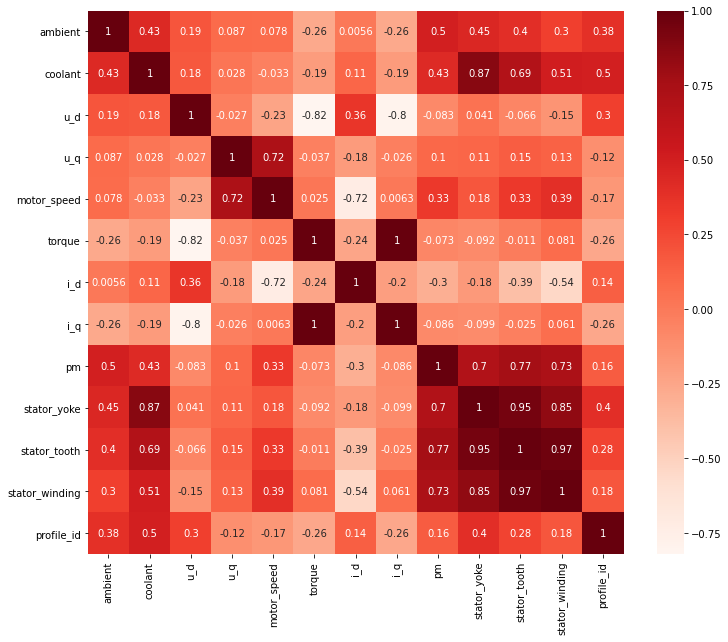

In [16]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [17]:
#Correlación respecto a la variable de salida o target
cor_target = abs(cor["pm"])

#Selección de características altamente correlacionadas
relevant_features = cor_target[cor_target>0.5]
relevant_features

ambient           0.501496
pm                1.000000
stator_yoke       0.695014
stator_tooth      0.768352
stator_winding    0.729561
Name: pm, dtype: float64

se puede observar que, sólo las características ambient, stator_yoke, stator_tooth y stator_winding están altamente correlacionadas con la variable target pm. Por lo tanto, ignoraremos las demás características. Sin embargo, este no es el final del proceso. Una de las suposiciones de la regresión lineal es que las variables independientes necesitan ser descorrelacionadas entre sí. Es decir, si estas variables están correlacionadas entre sí, entonces necesitamos mantener sólo una de ellas y eliminar el resto. Así que vamos a comprobar la correlación de las características seleccionadas entre sí. Esto se puede hacer ya sea comprobando visualmente desde la matriz de correlación de arriba o desde el fragmento de código de abajo.

In [18]:
print(df[["ambient","stator_tooth"]].corr())
print(df[["ambient","stator_yoke"]].corr())
print(df[["ambient","stator_winding"]].corr())
print(df[["stator_yoke","stator_tooth"]].corr())
print(df[["stator_yoke","stator_winding"]].corr())
print(df[["stator_winding","stator_tooth"]].corr())

               ambient  stator_tooth
ambient       1.000000      0.396742
stator_tooth  0.396742      1.000000
              ambient  stator_yoke
ambient      1.000000     0.451616
stator_yoke  0.451616     1.000000
                 ambient  stator_winding
ambient         1.000000        0.301883
stator_winding  0.301883        1.000000
              stator_yoke  stator_tooth
stator_yoke      1.000000      0.949898
stator_tooth     0.949898      1.000000
                stator_yoke  stator_winding
stator_yoke        1.000000        0.845144
stator_winding     0.845144        1.000000
                stator_winding  stator_tooth
stator_winding        1.000000      0.965633
stator_tooth          0.965633      1.000000


Del código anterior, se ve que las variables stator_tooth y stator_winding están altamente correlacionadas entre sí, al igual que las variables stator_yoke y stator_winding, y las variables stator_yoke y stator_tooth. Por lo tanto, mantendríamos sólo una variable y dejaríamos la otra. Mantendremos stator_tooth ya que su correlación con pm es la mayor. Después de dejar stator_yoke y stator_winding , nos quedan 2 características,stator_tooth y ambient. Estas son las últimas características dadas por la correlación de Pearson.

### Wrapper Method


El "método de envoltura" necesita un algoritmo de aprendizaje automático y utiliza su rendimiento como criterio de evaluación. Esto significa que se alimentan las funciones al algoritmo de aprendizaje automático seleccionado y, en función del rendimiento del modelo, se añaden o eliminan funciones. Se trata de un proceso iterativo y costoso desde el punto de vista computacional, pero es más preciso que el método de filtrado. Existen diferentes métodos de envoltura como la eliminación hacia atrás (Backward Elimination), la selección hacia adelante (Forward Selection), la eliminación bidireccional (Bidirectional Elimination) y la eliminación recursiva de características RFE. Discutiremos la eliminación hacia atrás y RFE aquí

## Backward Elimination
Al principio alimentamos el modelo con todas las características posibles, comprobamos el rendimiento del modelo y luego eliminamos las características de peor rendimiento una por una hasta que el rendimiento total del modelo se encuentre en un rango aceptable. La métrica de rendimiento utilizada aquí para evaluar el rendimiento de las características es pvalue. Si el valor p es superior a 0.05, entonces eliminamos la característica, de otro modo la mantenemos. Primero ejecutaremos una iteración aquí sólo para tener una idea del concepto y luego ejecutaremos el mismo código en un bucle, lo que dará el conjunto final de características. Aquí estamos usando el modelo OLS que significa "Ordinary Least Squares". Este modelo se utiliza para realizar una regresión lineal.

In [19]:
#Agregar una columna constante de unos, obligatorio para el modelo sm.OLS
X_1 = sm.add_constant(X)

#Ajuste del modelo sm.OLS
model = sm.OLS(y,X_1).fit()
model.pvalues.sort_values(ascending=False)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


i_q                1.836795e-06
torque             2.492762e-12
u_d               5.959958e-104
profile_id         0.000000e+00
stator_winding     0.000000e+00
stator_tooth       0.000000e+00
stator_yoke        0.000000e+00
i_d                0.000000e+00
motor_speed        0.000000e+00
u_q                0.000000e+00
coolant            0.000000e+00
ambient            0.000000e+00
const              0.000000e+00
dtype: float64

Como vemos, ninguna variable es mayor que 0.05. Por lo tanto conservamos todas las variables

In [20]:
#Backward Elimination
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d', 'i_q', 'stator_yoke', 'stator_tooth', 'stator_winding', 'profile_id']


## Recursive Feature Elimination (RFE)
El método recursivo de eliminación de características (RFE) funciona mediante la eliminación recursiva de atributos y la construcción de un modelo sobre los atributos que quedan. Utiliza una métrica de precisión para clasificar la característica según su importancia. El método RFE toma como entrada el modelo a ser utilizado y el número de características requeridas. A continuación, proporciona la clasificación de todas las variables, siendo 1 la más importante y en descendencia las menos importantes; viéndolo de forma más concisa, True la característica relevante y False la característica irrelevante.

In [21]:
model = LinearRegression()

#Método RFE
rfe = RFE(model, 7, verbose=1)

#Transformando los datos usando el método RFE
X_rfe = rfe.fit_transform(X,y)  

#Encontrando el modelo de los datos
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
[ True  True False  True  True False False False  True  True  True False]
[1 1 3 1 1 5 2 4 1 1 1 6]


Aquí tomamos el modelo LinearRegression con 7 características y RFE dio la clasificación de características como arriba, pero la selección del número '7' fue aleatoria, pudimos haber puesto '3' u '11'. Ahora necesitamos encontrar este número óptimo de características, para las cuales la precisión es la más alta. Esto lo hacemos usando el bucle que empieza con 1 característica y sube hasta 13. Luego tomamos la característica para la cual la precisión es más alta.

In [22]:
#Número de características
nof_list = np.arange(1,13)            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)
print("Desempeño con %d características: %f" % (nof, high_score))

Número óptimo de características: 12
Desempeño con 12 características: 0.774047


Como se ve en el código anterior, el número óptimo de características es 12. Ahora alimentamos 12 como número de características a RFE y obtenemos el conjunto final de características dadas por el método RFE.

In [0]:

cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 12)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Embedded Method
Los métodos integrados se ocupa de cada iteración del proceso de entrenamiento del modelo y extrae cuidadosamente las características que más contribuyen al entrenamiento para una iteración en particular. Los métodos de regularización son los métodos integrados más utilizados, ya que penalizan una característica dado un umbral. Entonces haremos la selección de características mediante un método integrado, usando la regularización de Lasso:

"Si la característica es irrelevante, Lasso penaliza su peso y lo convierte en 0. Por lo tanto, las características con peso = 0 se eliminan y el resto se toman."

In [23]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,y))

Número óptimo de características:11
Desempeño mediante la regularización Lasso: 0.762829


Text(0.5, 1.0, 'Importancia de las características usando el modelo de Lasso')

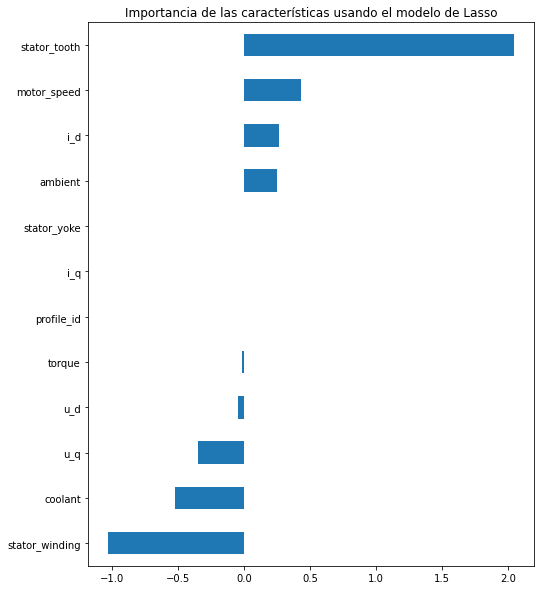

In [24]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Importancia de las características usando el modelo de Lasso")